# 다양한 모델로 살펴보는 캘리포니아 집값 예측(회귀)

## Workflow

일반적인 예측 모델링 프로젝트(predictive modeling)는 다음과 같은 프로세스를 따른다.

![Workflow](./imags/workflow.png)

### 탐색적 자료 분석 (EDA : Exploratory Data Analysis)

시각화와 기술 통계(Descriptive statistics)를 통해서 데이터를 이해하는 단계이다.

### 전처리 (Preprocessing)

데이터를 정제하고 가공해서 머신 러닝 모델의 입력에 적합한 형태로 바꿔주는 단계이다.

- Data Cleaning
  - Deduplication
  - Outlier detection
  - Other cleaning techniques

- For model
  - Feature extraction
  - Feature scaling
  - Dummification
  - Dimensionality reduction

탐색적 자료 분석과 전처리는 순차적이라기 보다 반복적인 관계이다. EDA를 통해 어떤 전처리가 필요한지 알 수 있고 전처리를 통해 EDA를 수월하게 할 수 있다.

### 모델 선택 (Model selection)

적절한 머신 러닝 모델을 선택하는 단계이다.

- 무엇을 선택할 것인가
  - Model
  - Features
  - Hyperparameters

- 어떻게 선택할 것인가
  - Metrics
  - Validation
  - Cross Validation (CV)

### 평가 및 예측 (Evaluation & Prediction)

만들어진 머신 러닝 모델의 성능을 평가하고 모델을 활용하여 새로운 데이터에 대한 예측을 하는 단계이다.

- 만들어진 모델이 얼마나 새로운 데이터에 대해 얼마나 일반화 (generalization) 가능한지 측정할 수 있다.
- 평가용 데이터셋은 모델 선택과 학습 과정에서 쓰이지 않아야 한다.
- 평가용 데이터셋은 학습용 데이터셋과 동일한 전처리 과정을 거쳐야 한다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
data = pd.read_csv('datas/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.columns.values

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'], dtype=object)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 전처리 (Preprocessing)

이 데이터셋은 잘 정제된 데이터셋이기 때문에 중복된 값이나 불량 데이터가 없다. 따라서 여기서는 Feature scaling 정도의 간단한 전처리만을 수행해보자.

### Feature scaling

- 0~1 사이에 맞추기
    - 최솟값을 빼고 (최댓값 - 최솟값)으로 나눈다.
    - 최댓값은 1이 되고, 최솟값은 0이 된다.

- 표준화(Standardization)하기
    - 평균을 빼고 표준편차로 나눈다.
    - 원래 분포가 정규분포인 경우 평균이 0이고 표준편차가 1인 표준정규분포로 바뀐다.
    - 대부분의 값이 -2 ~ 2 사이에 위치한다.

이 예시에서는 표준화(Standardization)를 쓴다.

학습 데이터셋의 전처리 과정에서 사용한 매개변수(parameter)는 테스트에서 동일하게 사용해야 한다. 이 예시에서는 학습 데이터셋에서 구한 변수의 평균과 표준편차를 저장해놓고 테스트에서 동일하게 사용할 것이다.

## 전처리(NaN, Missing Value)

In [6]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- 한 블록 내의 최대 침실 수는 6445개이고 평균 침실 수는 537개임을 알 수 있습니다. 데이터가 왜곡된 것 같으므로 히스토그램을 통해 이를 확인하겠습니다.

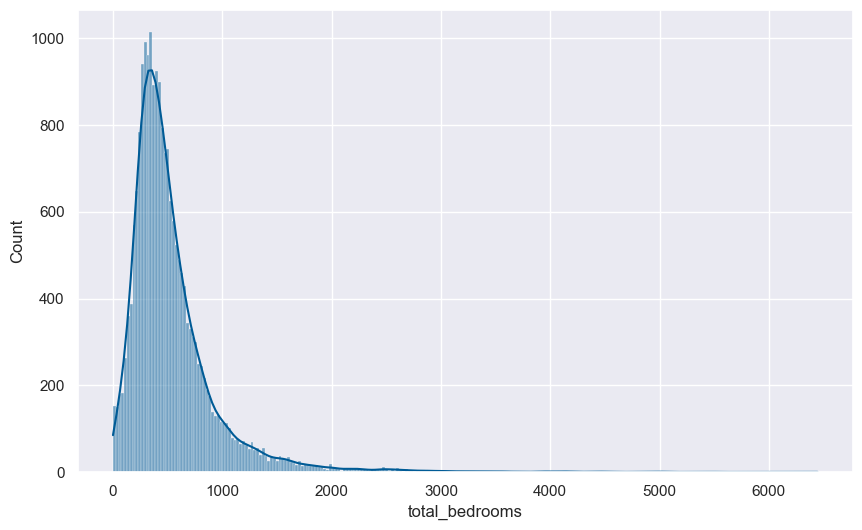

In [8]:
plt.figure(figsize= (10, 6))
sns.histplot(data['total_bedrooms'], color = '#005b96', kde= True);

- 확실히 왜곡되어 있으므로 누락된 값은 블록 내 객실 수 중앙값으로 채웁니다.

In [9]:
data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace= True)

## EDA

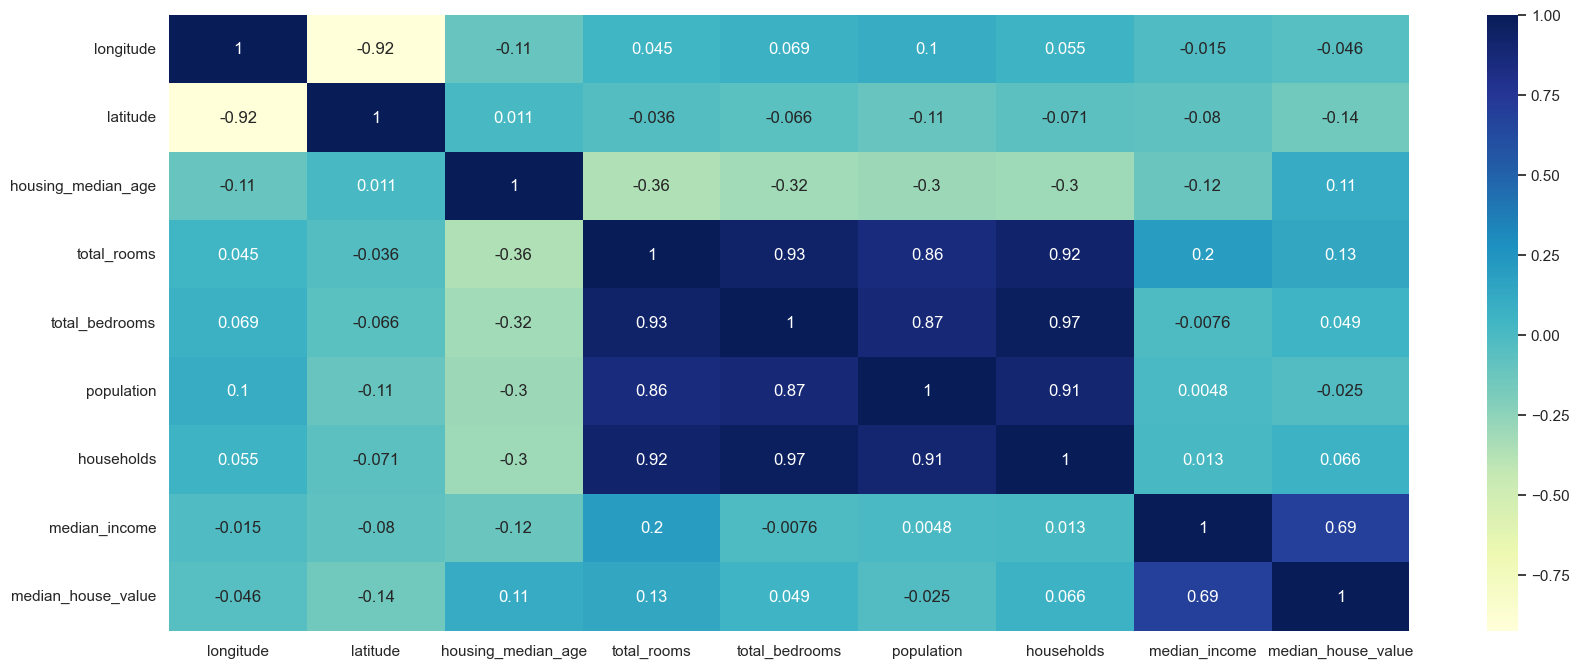

In [10]:
plt.figure(figsize= (20, 8))
sns.heatmap(data.corr(numeric_only=True), annot= True, cmap='YlGnBu')
plt.show()

- 중위소득은 분명 가장 중요한 특징입니다.

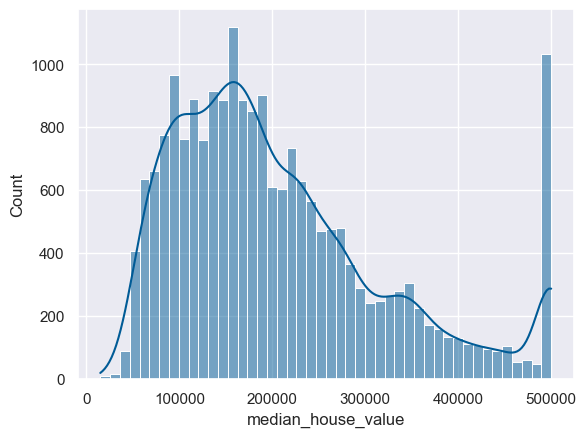

In [15]:
sns.histplot(data['median_house_value'], color = '#005b96', kde= True);

In [16]:
data['median_house_value'].skew()

0.9777632739098341

- 우리의 목표 변수는 분명히 왜곡되어 있습니다. 따라서 로그 변환을 늦게 적용할 것입니다.

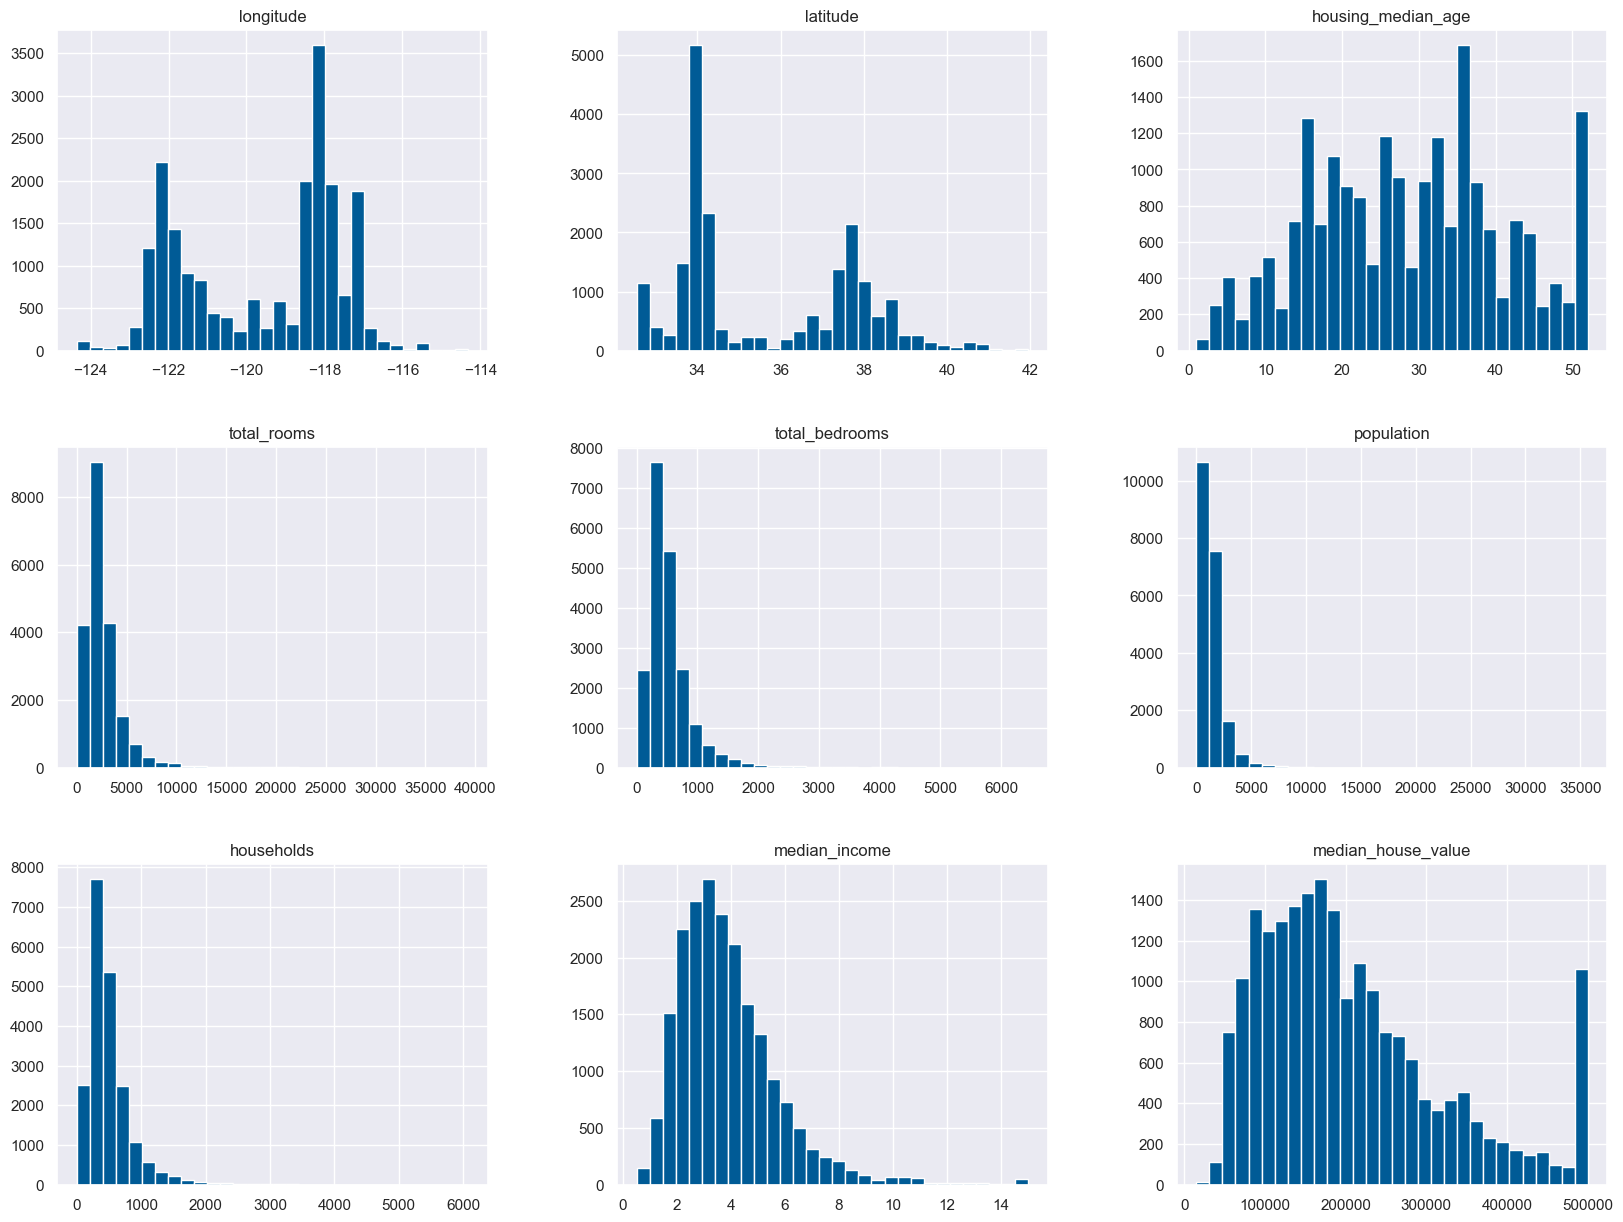

In [17]:
data.hist(bins = 30, figsize=(20, 15), color = '#005b96');

많은 기능이 왜곡되어 있다는 것을 분명히 알 수 있습니다. 따라서 나중에 기능 변환을 수행할 때 이 문제를 해결해야 할 것입니다.

어떻게 들여다봐도 문제가 많은 데이터..?, 범주형 변수도 같이 확인해보죠

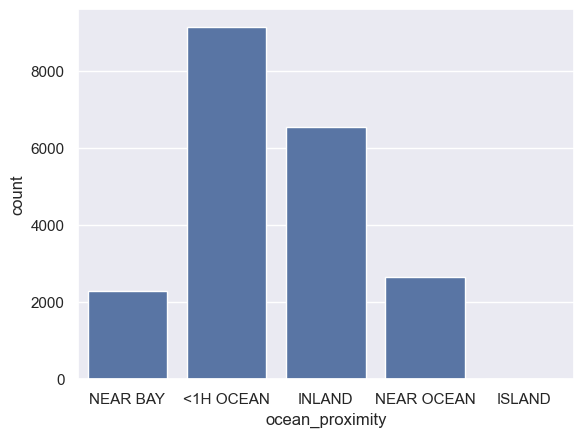

In [18]:
sns.countplot(x = data['ocean_proximity']);

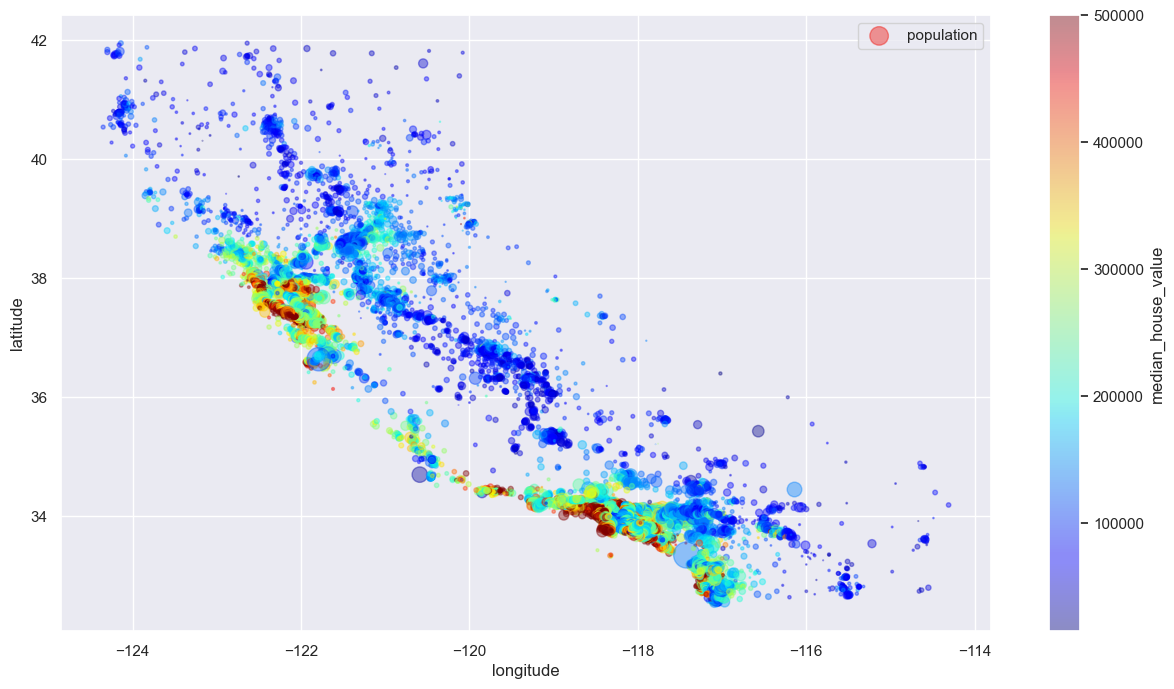

In [19]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=data["population"]/100, label="population", figsize=(15,8),
        c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()
plt.show()

### 특성공학

In [20]:
data['bed_per_room'] = data['total_bedrooms'] / data['total_rooms']

In [21]:
X = data.drop(['median_house_value'], axis=1)
y = np.log(data.median_house_value) # 로그 변환

## 특성 변환

In [22]:
skew_df = pd.DataFrame(X.select_dtypes(np.number).columns, columns= ['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(X[feature]))
skew_df['Abs_Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Abs_Skew'].apply(lambda x: True if x > 0.5 else False)
skew_df

,Feature,Skew,Abs_Skew,Skewed
0,longitude,-0.297780,0.297780,False
1,latitude,0.465919,0.465919,False
2,housing_median_age,0.060326,0.060326,False
3,total_rooms,4.147042,4.147042,True
4,total_bedrooms,3.480888,3.480888,True
5,population,4.935500,4.935500,True
6,households,3.410190,3.410190,True
7,median_income,1.646537,1.646537,True
8,bed_per_room,6.316445,6.316445,True


In [23]:
skewed_columns = skew_df[skew_df['Abs_Skew'] > 0.5]['Feature'].values
skewed_columns

array(['total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'bed_per_room'], dtype=object)

In [24]:
for column in skewed_columns:
    X[column] = np.log(X[column])

### Encoding

In [25]:
encoder=LabelEncoder()
X['ocean_proximity']=encoder.fit_transform(X['ocean_proximity'])

### Scaling

In [26]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,bed_per_room
0,-122.23,37.88,41.0,6.779922,4.859812,5.774552,4.836282,2.119287,3,-1.920110
1,-122.22,37.86,21.0,8.867709,7.008505,7.783641,7.037028,2.116424,3,-1.859204
2,-122.24,37.85,52.0,7.290975,5.247024,6.206576,5.176150,1.982022,3,-2.043951
3,-122.25,37.85,52.0,7.149917,5.459586,6.324359,5.389072,1.730434,3,-1.690331
4,-122.25,37.85,52.0,7.394493,5.634790,6.336826,5.556828,1.347086,3,-1.759704


In [27]:
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index= X.index, columns= X.columns)


## 데이터 나누기

## 모델 생성

### Linear Regression

RMSE: 0.3452750790518536
R-square: 0.632694341236971


### Random Forest

RMSE: 0.2326154007199106
R-square: 0.8332852284527665


### Gradient Boosting

RMSE: 0.2677407335289869
R-square: 0.7791354319598811


## 모델 결정

In [38]:
final_predictions = (
    0.25 * predictions_gbr +
    0.45 * predictions_rf +
    0.25 * predictions_lr
)

In [39]:
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
r2 = r2_score(y_test, final_predictions)

print('RMSE:', rmse)
print('R-square:', r2)

RMSE: 0.25734508963514424
R-square: 0.7959536058892902


In [40]:
final_predictions

array([10.96640578, 11.37383425, 12.68170243, ..., 13.03892281,
       11.33978558, 12.08564361])

최종 예측을 원래 규모로 되돌리려면 최종 예측의 지수를 취해야 합니다.

In [41]:
final_predictions = np.exp(final_predictions)
y_test = np.exp(y_test)

In [42]:
pd.DataFrame({'Actual': y_test, 'Predicted': final_predictions.round(2)})

,Actual,Predicted
20046,47700.0,57896.13
3024,45800.0,87014.87
15663,500001.0,321805.44
20484,218600.0,268846.06
9814,278000.0,252863.32
...,...,...
15362,263300.0,210085.43
16623,266800.0,207766.39
18086,500001.0,459972.88
2144,72300.0,84102.00


## 결과 확인

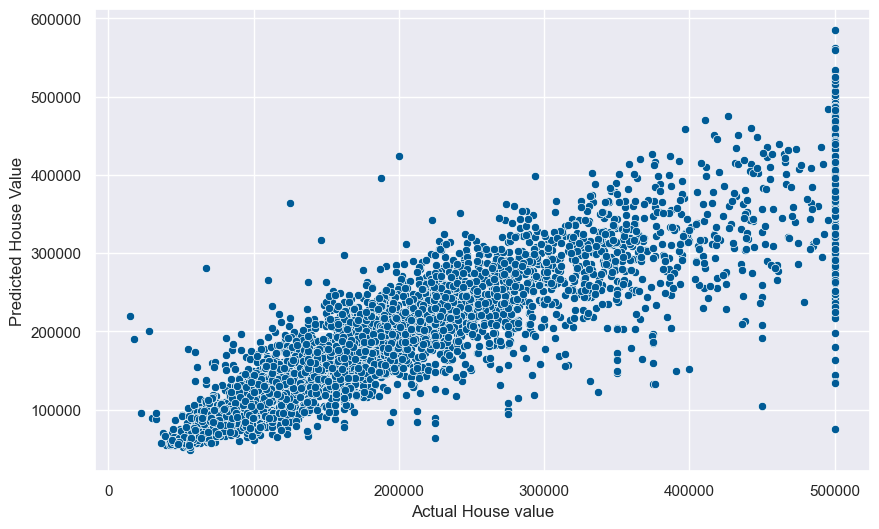

In [43]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
plt.xlabel('Actual House value')
plt.ylabel('Predicted House Value')
plt.show()

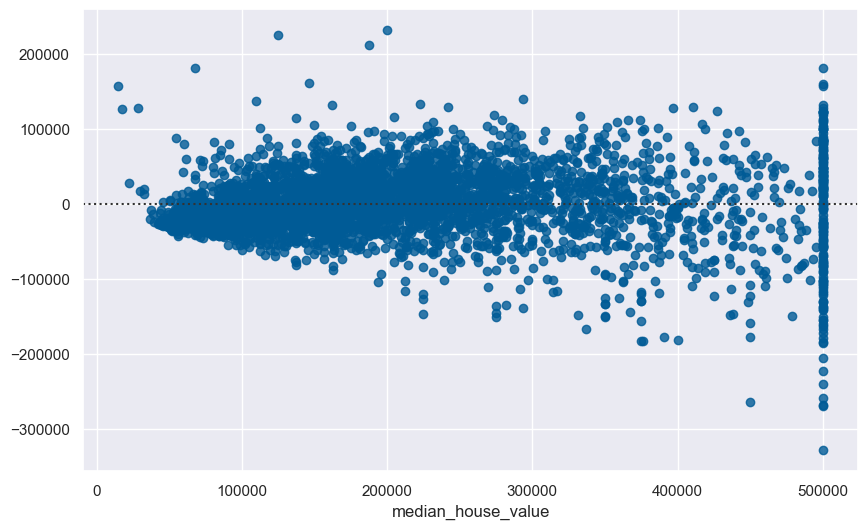

In [44]:
plt.figure(figsize= (10, 6))
sns.residplot(x= y_test, y = final_predictions, color= '#005b96')
plt.show()

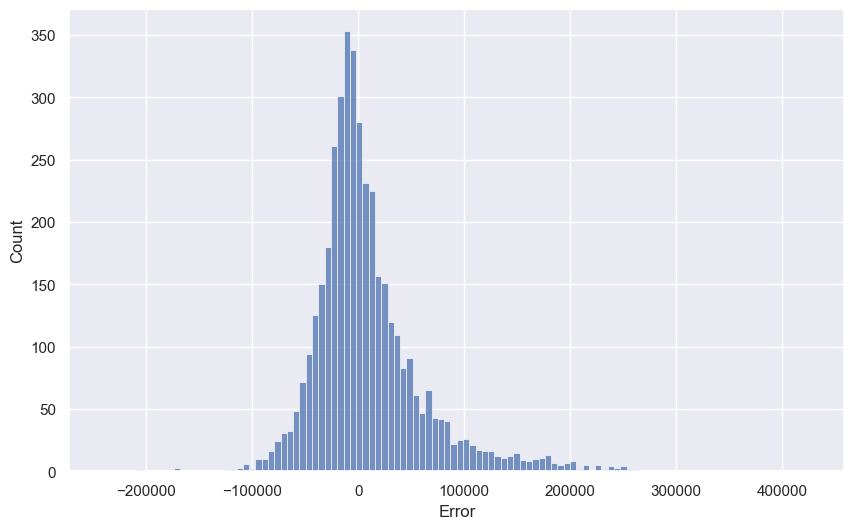

In [45]:
resid = y_test - final_predictions
plt.figure(figsize= (10, 6))
sns.histplot(resid)
plt.xlabel('Error');